In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_153882/687462750.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

In [4]:
features = ['Lag_1_Status', 'Count_Alpa_7D', 'Count_Alpa_30D', 'Streak_Alpa', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

/tmp/ipykernel_153882/3542950029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


In [5]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 89658 baris
Data Uji: 22415 baris


In [6]:
dt = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=25, min_samples_leaf=30, min_samples_split=2)
rf = RandomForestClassifier(random_state=42, max_depth=3, max_features=2, min_samples_split=2, n_estimators=80)
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, colsample_bytree=0.7, gamma=3, learning_rate=0.2, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=1, seed=0)
nb = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', GaussianNB(var_smoothing=1e-09))
        ])
svm = Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(random_state=42, C=0.5, gamma='scale', kernel='rbf'))
        ])

In [7]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Data latih setelah resampling: {X_train_res.shape[0]} baris")


Data latih setelah resampling: 107680 baris


Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     15074
           1       0.46      0.50      0.48      7341

    accuracy                           0.65     22415
   macro avg       0.60      0.61      0.61     22415
weighted avg       0.65      0.65      0.65     22415



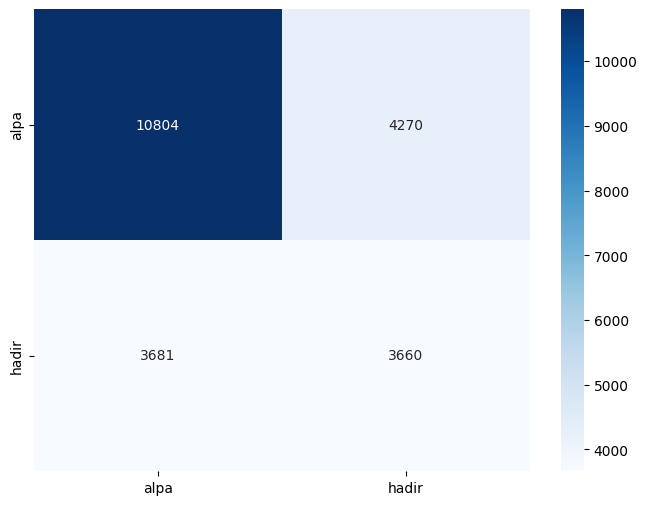

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     15074
           1       0.48      0.45      0.46      7341

    accuracy                           0.66     22415
   macro avg       0.61      0.61      0.61     22415
weighted avg       0.66      0.66      0.66     22415



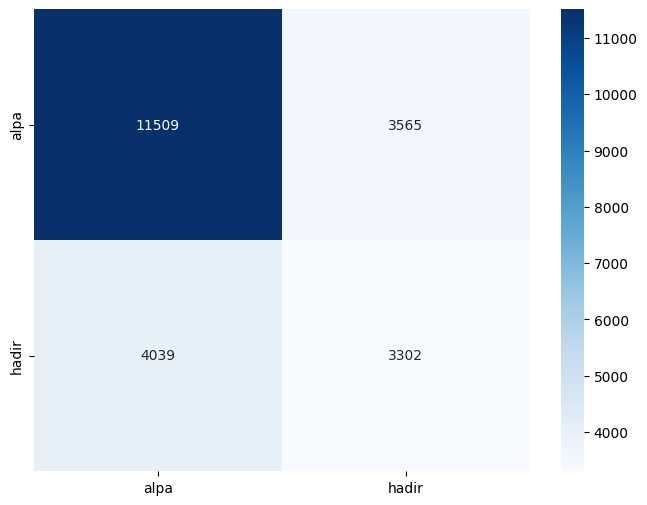

Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.73      0.66      0.69     15074
           1       0.42      0.51      0.46      7341

    accuracy                           0.61     22415
   macro avg       0.58      0.58      0.58     22415
weighted avg       0.63      0.61      0.62     22415



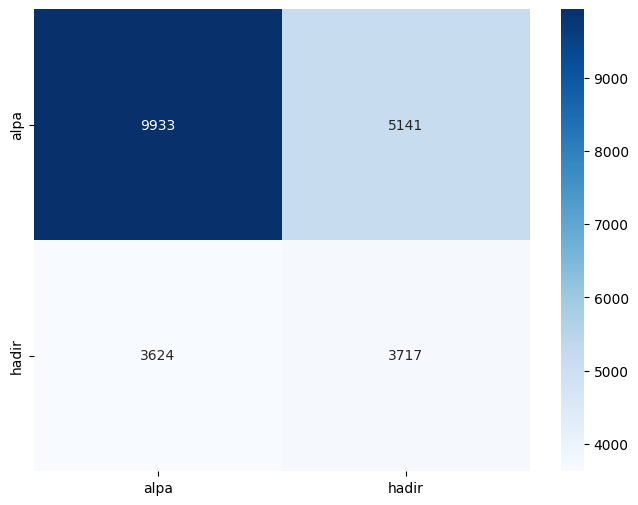

Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.58      0.67     15074
           1       0.44      0.68      0.53      7341

    accuracy                           0.61     22415
   macro avg       0.61      0.63      0.60     22415
weighted avg       0.67      0.61      0.62     22415



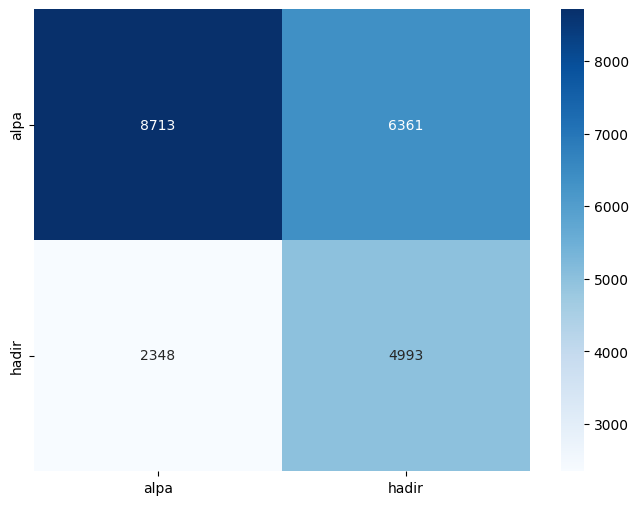

Classification Report for SVM
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     15074
           1       0.48      0.51      0.49      7341

    accuracy                           0.66     22415
   macro avg       0.61      0.62      0.62     22415
weighted avg       0.66      0.66      0.66     22415



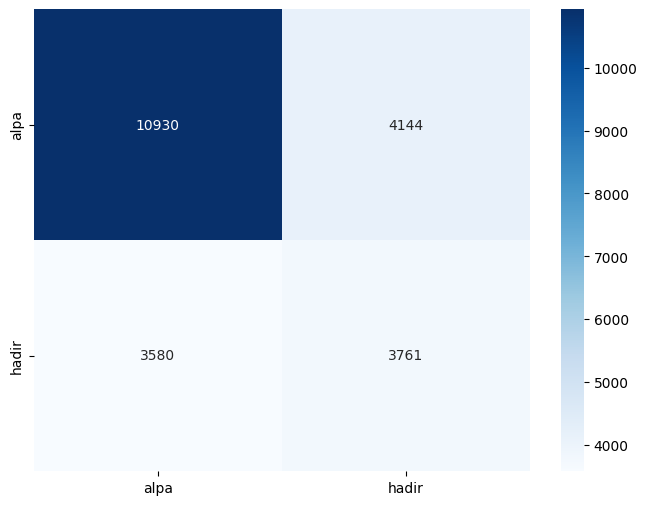

In [8]:
models = {
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgb,
    'Naive Bayes': nb,
    'SVM': svm
}
results = []

for name, model in models.items():
    y_pred = model.fit(X_train_res, y_train_res).predict(X_test)
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro Precision': report['macro avg']['precision']
    })
    print("Classification Report for", name)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.show()


In [10]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1,Macro Recall,Macro Precision
0,Decision Tree,0.645282,0.605176,0.607650,0.603707
1,Random Forest,0.660763,0.608245,0.606651,0.610537
2,XGBoost,0.608967,0.576390,0.582642,0.576152
3,Naive Bayes,0.611466,0.600461,0.629084,0.613740
4,SVM,0.655409,0.616144,0.618709,0.614524


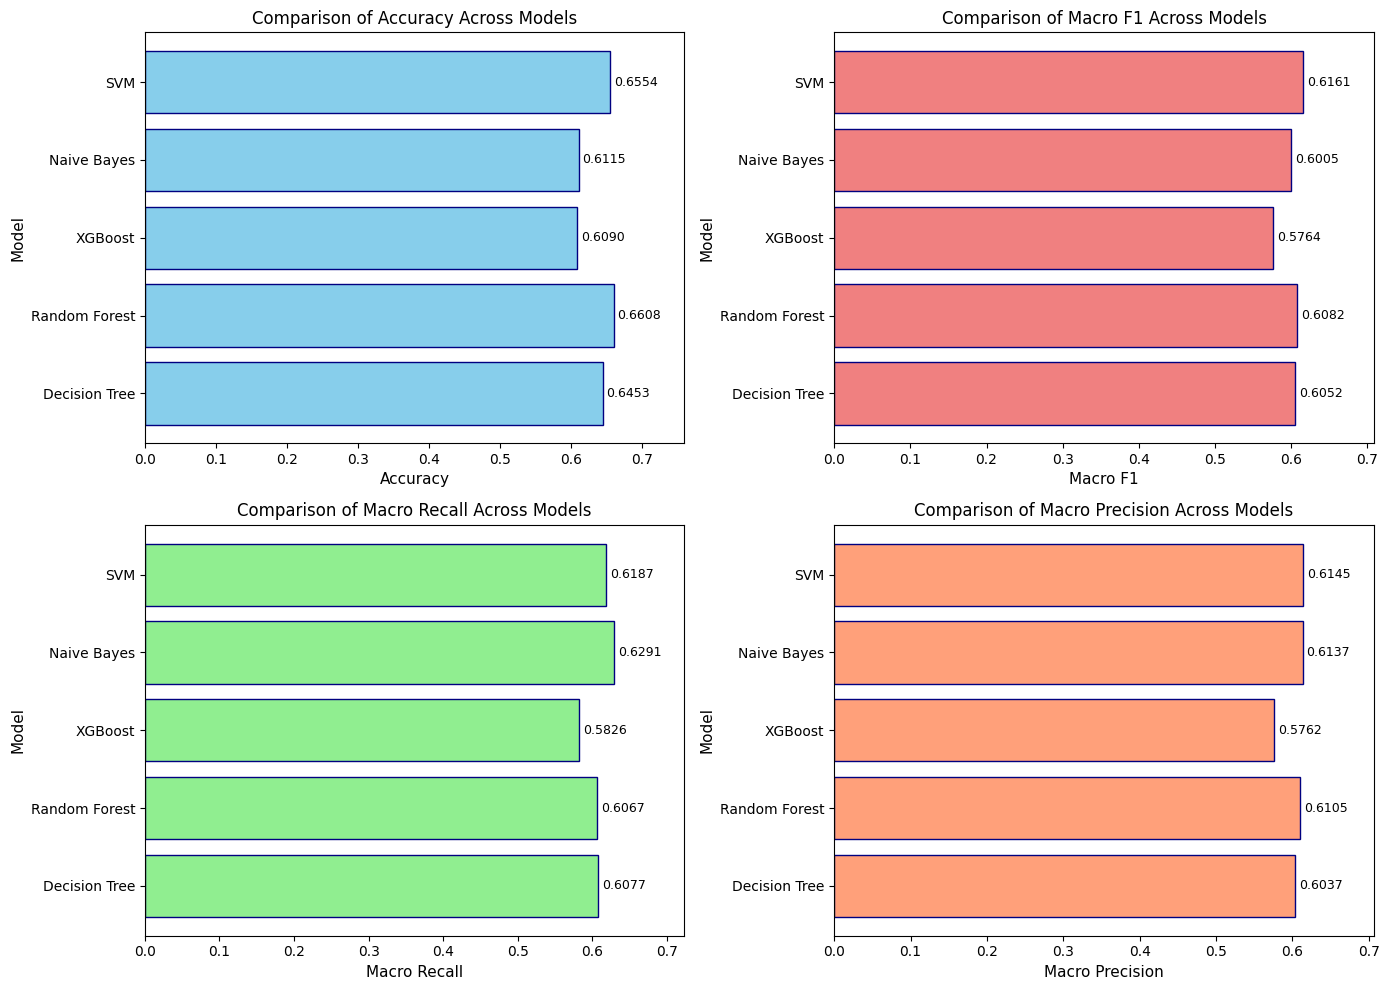

In [11]:
# Create subplots for all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Macro F1', 'Macro Recall', 'Macro Precision']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
  ax.barh(results_df['Model'], results_df[metric], color=color, edgecolor='navy')
  ax.set_xlabel(metric, fontsize=11)
  ax.set_ylabel('Model', fontsize=11)
  ax.set_title(f'Comparison of {metric} Across Models', fontsize=12)
  ax.set_xlim(0, max(results_df[metric]) * 1.15)
  
  # Add value labels on bars
  for i, (model, score) in enumerate(zip(results_df['Model'], results_df[metric])):
    ax.text(score + 0.005, i, f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()